# An Introduction to Linear Learner with MNIST
_**Making a Binary Prediction of Whether a Handwritten Digit is a 0**_

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
3. [Training the linear model](#Training-the-linear-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Validate the model for use](#Validate-the-model-for-use)


## Introduction

Welcome to our example introducing Amazon SageMaker's Linear Learner Algorithm!  Today, we're analyzing the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset which consists of images of handwritten digits, from zero to nine.  We'll use the individual pixel values from each 28 x 28 grayscale image to predict a yes or no label of whether the digit is a 0 or some other digit (1, 2, 3, ... 9).

The method that we'll use is a linear binary classifier.  Linear models are supervised learning algorithms used for solving either classification or regression problems.  As input, the model is given labeled examples ( **`x`**, `y`). **`x`** is a high dimensional vector and `y` is a numeric label.  Since we are doing binary classification, the algorithm expects the label to be either 0 or 1 (but Amazon SageMaker Linear Learner also supports regression on continuous values of `y`).  The algorithm learns a linear function, or linear threshold function for classification, mapping the vector **`x`** to an approximation of the label `y`.

Amazon SageMaker's Linear Learner algorithm extends upon typical linear models by training many models in parallel, in a computationally efficient manner.  Each model has a different set of hyperparameters, and then the algorithm finds the set that optimizes a specific criteria.  This can provide substantially more accurate models than typical linear algorithms at the same, or lower, cost.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
prefix = 'sagemaker/DEMO-linear-mnist'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [13]:
# read csv file into pandas
import pandas as pd
bucket='yifenghe2019'
data_key = 'friends.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
df = pd.read_csv(data_location)
df.head()

,ID,age,name,numFriends
0,0,33,Will,385
1,1,26,Jean-Luc,2
2,2,55,Hugh,221
3,3,40,Deanna,465
4,4,68,Quark,21


In [6]:
# list files
s3 = boto3.resource('s3')
bucket = s3.Bucket('yifenghe2019')
for obj in bucket.objects.all():
    print(obj.key)

2018-08-15
2018-08-15/
2018-08-15/2018-08-15_BINS_XETR00.csv
2018-08-15/2018-08-15_BINS_XETR01.csv
2018-08-15/2018-08-15_BINS_XETR02.csv
2018-08-15/2018-08-15_BINS_XETR03.csv
2018-08-15/2018-08-15_BINS_XETR04.csv
2018-08-15/2018-08-15_BINS_XETR05.csv
2018-08-15/2018-08-15_BINS_XETR06.csv
2018-08-15/2018-08-15_BINS_XETR07.csv
2018-08-15/2018-08-15_BINS_XETR08.csv
2018-08-15/2018-08-15_BINS_XETR09.csv
2018-08-15/2018-08-15_BINS_XETR10.csv
2018-08-15/2018-08-15_BINS_XETR11.csv
2018-08-15/2018-08-15_BINS_XETR12.csv
2018-08-15/2018-08-15_BINS_XETR13.csv
2018-08-15/2018-08-15_BINS_XETR14.csv
2018-08-15/2018-08-15_BINS_XETR15.csv
2018-08-15/2018-08-15_BINS_XETR16.csv
2018-08-15/2018-08-15_BINS_XETR17.csv
2018-08-15/2018-08-15_BINS_XETR18.csv
2018-08-15/2018-08-15_BINS_XETR19.csv
2018-08-15/2018-08-15_BINS_XETR20.csv
2018-08-15/2018-08-15_BINS_XETR21.csv
2018-08-15/2018-08-15_BINS_XETR22.csv
2018-08-15/2018-08-15_BINS_XETR23.csv
data/
data/11.txt
data/friends.csv
friends.csv
friends2.csv
input

In [18]:
#To list all the files in the folder path/to/my/folder in my-bucket:
files = list(bucket.objects.filter(Prefix='data/'))
files

[s3.ObjectSummary(bucket_name='yifenghe2019', key='data/'),
 s3.ObjectSummary(bucket_name='yifenghe2019', key='data/11.txt'),
 s3.ObjectSummary(bucket_name='yifenghe2019', key='data/friends.csv')]

In [19]:
obj3 = files[2].get()

In [22]:
obj3

{'ResponseMetadata': {'RequestId': '2EB5C8B7D82D9BD0',
  'HostId': 'FrzMQ2iR+0HYOx5JdIETNzW7Fh0juoDoy+ZNE+sWbcldsjI2wdrKuh66Z1QvcuBYh9qB+iDxgMg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'FrzMQ2iR+0HYOx5JdIETNzW7Fh0juoDoy+ZNE+sWbcldsjI2wdrKuh66Z1QvcuBYh9qB+iDxgMg=',
   'x-amz-request-id': '2EB5C8B7D82D9BD0',
   'date': 'Wed, 27 Feb 2019 21:30:40 GMT',
   'last-modified': 'Wed, 27 Feb 2019 20:54:37 GMT',
   'etag': '"340f94f5263e12049766b55141dc7ee6"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'content-length': '8277',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2019, 2, 27, 20, 54, 37, tzinfo=tzutc()),
 'ContentLength': 8277,
 'ETag': '"340f94f5263e12049766b55141dc7ee6"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f207851e860>}

In [25]:
df3=pd.read_csv(obj3['Body'])

In [30]:
files = list(bucket.objects.filter(Prefix='data/'))
for file in files:
    content = file.get()['Body'].read().decode('utf-8') 
    #print(content)


{'a': 1, 'b': 2}

ID,age,name,numFriends
0,33,Will,385
1,26,Jean-Luc,2
2,55,Hugh,221
3,40,Deanna,465
4,68,Quark,21
5,59,Weyoun,318
6,37,Gowron,220
7,54,Will,307
8,38,Jadzia,380
9,27,Hugh,181
10,53,Odo,191
11,57,Ben,372
12,54,Keiko,253
13,56,Jean-Luc,444
14,43,Hugh,49
15,36,Rom,49
16,22,Weyoun,323
17,35,Odo,13
18,45,Jean-Luc,455
19,60,Geordi,246
20,67,Odo,220
21,19,Miles,268
22,30,Quark,72
23,51,Keiko,271
24,25,Julian,1
25,21,Ben,445
26,22,Julian,100
27,42,Leeta,363
28,49,Martok,476
29,48,Nog,364
30,50,Keiko,175
31,39,Miles,161
32,26,Nog,281
33,53,Dukat,197
34,43,Jean-Luc,249
35,27,Beverly,305
36,32,Kasidy,81
37,58,Geordi,21
38,64,Deanna,65
39,31,Morn,192
40,52,Odo,413
41,67,Hugh,167
42,54,Brunt,75
43,58,Guinan,345
44,35,Nerys,244
45,52,Dukat,77
46,25,Morn,96
47,24,Brunt,49
48,20,Nog,1
49,40,Ezri,254
50,51,Quark,283
51,36,Lwaxana,212
52,19,Beverly,269
53,62,Geordi,31
54,19,Brunt,5
55,41,Keiko,278
56,44,Gowron,194
57,57,Odo,294
58,59,Hugh,158
59,59,Morn,284
60,20,Geordi,100
61,62,Kasidy

In [52]:
obj = s3_client.get_object(Bucket='yifenghe2019', Key='data/44.txt')
txt = obj['Body'].read().decode('utf-8') 
txt

'{"abc": 23, "efg": 65}'

In [43]:
import json
str1='{"Python": ".py", "C++": ".cpp", "Java": ".java"}'
dict1=json.loads(txt)
dict1

{'abc': 23, 'efg': 65}

In [39]:
type(dict1)

dict

In [27]:
files[0].get()

{'ResponseMetadata': {'RequestId': '9094F65BC6339E6B',
  'HostId': 'soITilSG+oTMWviMhrbWTc8sCzZ31l82NRdMd/RcoNhO18ijGYWH9tBM2wHvRbdGDCH2TAmOShc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'soITilSG+oTMWviMhrbWTc8sCzZ31l82NRdMd/RcoNhO18ijGYWH9tBM2wHvRbdGDCH2TAmOShc=',
   'x-amz-request-id': '9094F65BC6339E6B',
   'date': 'Wed, 27 Feb 2019 21:35:12 GMT',
   'last-modified': 'Wed, 27 Feb 2019 20:54:16 GMT',
   'etag': '"d41d8cd98f00b204e9800998ecf8427e"',
   'accept-ranges': 'bytes',
   'content-type': 'application/x-directory',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2019, 2, 27, 20, 54, 16, tzinfo=tzutc()),
 'ContentLength': 0,
 'ETag': '"d41d8cd98f00b204e9800998ecf8427e"',
 'ContentType': 'application/x-directory',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f207846d668>}

In [28]:
s3_client = boto3.client('s3') #low-level functional API
obj = s3_client.get_object(Bucket='yifenghe2019', Key='data/friends.csv')
print(obj)
df_1 = pd.read_csv(obj['Body'])

{'ResponseMetadata': {'RequestId': '26B438F00D891B5A', 'HostId': '0iPN3G1j6cam68u/sf+JBKQ3n3k2e2ZCYZRxfXwS1bd7dMs9XPVx+J44qUMJ2B3StG6qUNQT1eE=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': '0iPN3G1j6cam68u/sf+JBKQ3n3k2e2ZCYZRxfXwS1bd7dMs9XPVx+J44qUMJ2B3StG6qUNQT1eE=', 'x-amz-request-id': '26B438F00D891B5A', 'date': 'Wed, 27 Feb 2019 21:39:23 GMT', 'last-modified': 'Wed, 27 Feb 2019 20:54:37 GMT', 'etag': '"340f94f5263e12049766b55141dc7ee6"', 'accept-ranges': 'bytes', 'content-type': 'text/csv', 'content-length': '8277', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'AcceptRanges': 'bytes', 'LastModified': datetime.datetime(2019, 2, 27, 20, 54, 37, tzinfo=tzutc()), 'ContentLength': 8277, 'ETag': '"340f94f5263e12049766b55141dc7ee6"', 'ContentType': 'text/csv', 'Metadata': {}, 'Body': <botocore.response.StreamingBody object at 0x7f2078432cf8>}


In [29]:
df_1.head()

,ID,age,name,numFriends
0,0,33,Will,385
1,1,26,Jean-Luc,2
2,2,55,Hugh,221
3,3,40,Deanna,465
4,4,68,Quark,21


In [41]:
dict1={'abc': 23, 'efg': 65}
str1=json.dumps(dict1)
f=open('33.txt', 'w')
f.write(str1)
f.close()


In [51]:
s3_client = boto3.client('s3')
file_name_local = 'data/44.txt'
bucket='yifenghe2019'
s3_file_path = 'data/44.txt'
s3_client.upload_file(file_name_local, bucket, s3_file_path)

In [53]:
import boto3
import botocore
file_name_local = 'data/4400.txt'
bucket='yifenghe2019'
s3_file_path = 'data/44.txt'
s3_resource = boto3.resource('s3')
try:
    s3_resource.Bucket(bucket).download_file(s3_file_path, file_name_local)
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

### Data ingestion

Next, we read the dataset from an online URL into memory, for preprocessing prior to training. This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 927 ms, sys: 299 ms, total: 1.23 s
Wall time: 2.21 s


In [7]:
train_set[0].shape

(50000, 784)

### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

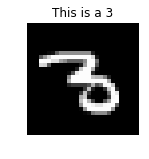

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

### Data conversion

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of Linear Learner takes recordIO-wrapped protobuf, where the data we have today is a pickle-ized numpy array on disk.

Most of the conversion effort is handled by the Amazon SageMaker Python SDK, imported as `sagemaker` below.

In [9]:
import io
import numpy as np
import sagemaker.amazon.common as smac

vectors = np.array([t.tolist() for t in train_set[0]]).astype('float32')
labels = np.where(np.array([t.tolist() for t in train_set[1]]) == 0, 1, 0).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

0

## Upload training data
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

In [14]:
import boto3
import os

key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://yifenghe2019/sagemaker/DEMO-linear-mnist/train/recordio-pb-data


Let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

In [ ]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

## Training the linear model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the Linear Learner training algorithm, although we have tested it on multi-terabyte datasets.

Again, we'll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed.  In this example that takes between 7 and 11 minutes.  Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

First, let's specify our containers.  Since we want this notebook to run in all 4 of Amazon SageMaker's regions, we'll create a small lookup.  More details on algorithm containers can be found in [AWS documentation](https://docs-aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

Next we'll kick off the base estimator, making sure to pass in the necessary hyperparameters.  Notice:
- `feature_dim` is set to 784, which is the number of pixels in each 28 x 28 image.
- `predictor_type` is set to 'binary_classifier' since we are trying to predict whether the image is or is not a 0.
- `mini_batch_size` is set to 200.  This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.

In [ ]:
import boto3
import sagemaker

sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=784,
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})

## Set up hosting for the model
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

_Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target._

In [ ]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

## Validate the model for use
Finally, we can now validate the model for use.  We can pass HTTP POST requests to the endpoint to get back predictions.  To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

Now let's try getting a prediction for a single record.

In [ ]:
result = linear_predictor.predict(train_set[0][30:31])
print(result)

OK, a single prediction works.  We see that for one record our endpoint returned some JSON which contains `predictions`, including the `score` and `predicted_label`.  In this case, `score` will be a continuous value between [0, 1] representing the probability we think the digit is a 0 or not.  `predicted_label` will take a value of either `0` or `1` where (somewhat counterintuitively) `1` denotes that we predict the image is a 0, while `0` denotes that we are predicting the image is not of a 0.

Let's do a whole batch of images and evaluate our predictive accuracy.

In [ ]:
import numpy as np

predictions = []
for array in np.array_split(test_set[0], 100):
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

In [ ]:
import pandas as pd

pd.crosstab(np.where(test_set[1] == 0, 1, 0), predictions, rownames=['actuals'], colnames=['predictions'])

As we can see from the confusion matrix above, we predict 931 images of 0 correctly, while we predict 44 images as 0s that aren't, and miss predicting 49 images of 0.

### (Optional) Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
import sagemaker

sagemaker.Session().delete_endpoint(linear_predictor.endpoint)